# ML Test: Modelos Predictivos de Clasificación Binaria de Clic sobre anuncio mediante técnicas de Aprendizaje Supervisado

Diego F. Osorio 

Machine Learning Engineer
MSc in Electronics and Computer Science (AI)

**Universidad de los Andes**

* Introducción
* Exploración
* ML Pipelines
* Evaluación
* Predicciones
* Conclusiones

# Librerias

In [2]:
# general
import numpy as np
import pandas as pd
import re
import os
import joblib
import pandas as pd
import random

# funciones
from funciones.data_exploration import explore
from funciones.feature_cleaning import missing_data, outlier, rare_values
from funciones.feature_cleaning import missing_data as ms
from funciones.feature_cleaning import outlier as ot
from funciones.feature_cleaning import rare_values as ra
from funciones.feature_engineering import discretization, encoding, transformation
from funciones.feature_selection import embedded_method, feature_shuffle, filter_method, hybrid


# visualización
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import warn
from pandas.plotting import scatter_matrix
plt.style.use('seaborn-colorblind')
#from data_exploration import explore


# preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

# ML
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
import pylab
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# ML pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel


from sklearn import set_config



C:\Users\Diego\AppData\Local\Temp\ipykernel_17312\1682980043.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


# Generar Base de datos

In [3]:
# Number of samples
n_samples = 1000

# Generate the sample data
data = {
    'copy': [random.choice(["50% off!", "Buy now!", "Limited offer!", "Best in town!", "Hurry up!", "Don't miss out!"]) for _ in range(n_samples)],
    'audience': [random.choice(["teens", "adults", "parents", "students", "elderly"]) for _ in range(n_samples)],
    'keywords': [random.choice(["sale", "discount", "offer", "limited", "exclusive", "bestseller"]) for _ in range(n_samples)],
    'time_of_day': [random.choice([i for i in range(24)]) for _ in range(n_samples)],  # 0 to 23 representing hours
    'clicked': [random.choice([0, 1]) for _ in range(n_samples)]
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Add some intentional patterns
for i in range(n_samples):
    if df.at[i, 'audience'] == 'elderly' and df.at[i, 'copy'] == "Hurry up!":
        df.at[i, 'clicked'] = 0  # Elderly audience might not respond well to a 'Hurry up!' message
    
    if df.at[i, 'time_of_day'] >= 6 and df.at[i, 'time_of_day'] <= 11 and df.at[i, 'keywords'] == 'sale':
        df.at[i, 'clicked'] = 1  # More people might click on 'sale' keyword ads in the morning hours

# Save the dataset to a CSV file
df.to_csv("data/ad_data.csv", index=False)

df

,copy,audience,keywords,time_of_day,clicked
0,Hurry up!,teens,bestseller,14,0
1,Hurry up!,teens,discount,16,1
2,Limited offer!,teens,bestseller,12,1
3,Don't miss out!,adults,sale,14,1
4,Limited offer!,teens,sale,16,0
...,...,...,...,...,...
995,Don't miss out!,teens,offer,23,0
996,Buy now!,parents,discount,20,1
997,Buy now!,students,limited,15,1
998,Buy now!,teens,exclusive,20,0


# Modelo Base: XGBoost default

In [12]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

data = pd.read_csv("ad_data.csv")

X = data.drop('clicked', axis=1)
y = data['clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:copy: object, audience: object, keywords: object

# Explicación del Error

El error en el código se debe a que se está intentado entrenar el modelo de ML XGBoost con variables (columnas) categóricas que todavía no se han preprocesado (codificado), por lo que el modelo no puede entrenarse correctamente. A continuación, se presenta el código corregido

# Preprocesamiento

# Exploración

* Análisis Descriptivo
* Análisis Estadístico
* Visualización
* Técnicas de correlación
* Aprendizaje no Supervisado

## Análisis Descriptivo

In [4]:
df 

,copy,audience,keywords,time_of_day,clicked
0,Hurry up!,teens,bestseller,14,0
1,Hurry up!,teens,discount,16,1
2,Limited offer!,teens,bestseller,12,1
3,Don't miss out!,adults,sale,14,1
4,Limited offer!,teens,sale,16,0
...,...,...,...,...,...
995,Don't miss out!,teens,offer,23,0
996,Buy now!,parents,discount,20,1
997,Buy now!,students,limited,15,1
998,Buy now!,teens,exclusive,20,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   copy         1000 non-null   object
 1   audience     1000 non-null   object
 2   keywords     1000 non-null   object
 3   time_of_day  1000 non-null   int64 
 4   clicked      1000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [6]:
# contar observaciones(fila) por clase de variable
df["clicked"].value_counts()

1    518
0    482
Name: clicked, dtype: int64

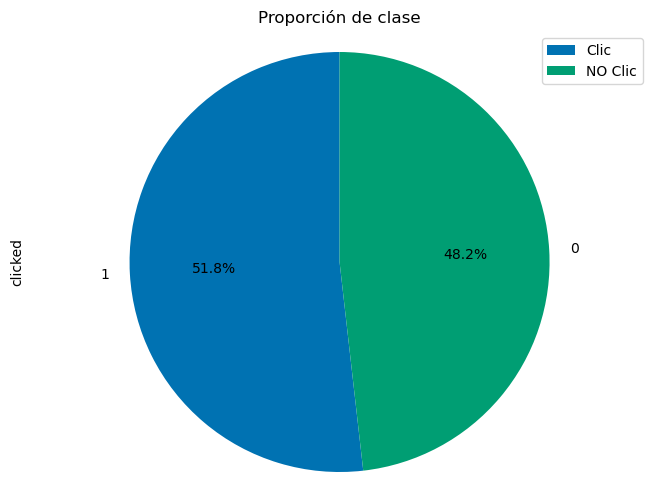

In [7]:
# calcular proporcion de clase

# variable y dependiente
df["clicked"].value_counts()
# calcular proporcion de clases
class_proportions = df["clicked"].value_counts(normalize=True)

# crear pie plot
plt.figure(figsize=(8, 6))
class_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proporción de clase')
plt.legend(labels=['Clic','NO Clic'], loc='best')
plt.axis('equal')

# Show the plot
plt.show()

1    0.518
0    0.482
Name: clicked, dtype: float64

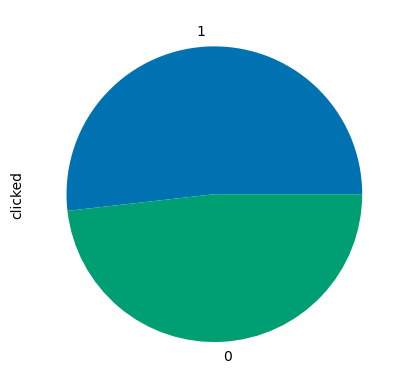

In [8]:
# distribucion de clases
# 1=clic, 0=no clic
df["clicked"].value_counts().plot(kind='pie')
df["clicked"].value_counts(normalize=True)

In [9]:
# análisis estadístico preliminar para variables numéricas
# contar observaciones(filas) por variable
# promedio, desviacion estandar
# valor máximo, mínnimo y cuantiles por columna (variable)

df.describe()

,time_of_day,clicked
count,1000.000000,1000.000000
mean,11.796000,0.518000
std,6.987217,0.499926
min,0.000000,0.000000
25%,6.000000,0.000000
50%,12.000000,1.000000
75%,18.000000,1.000000
max,23.000000,1.000000


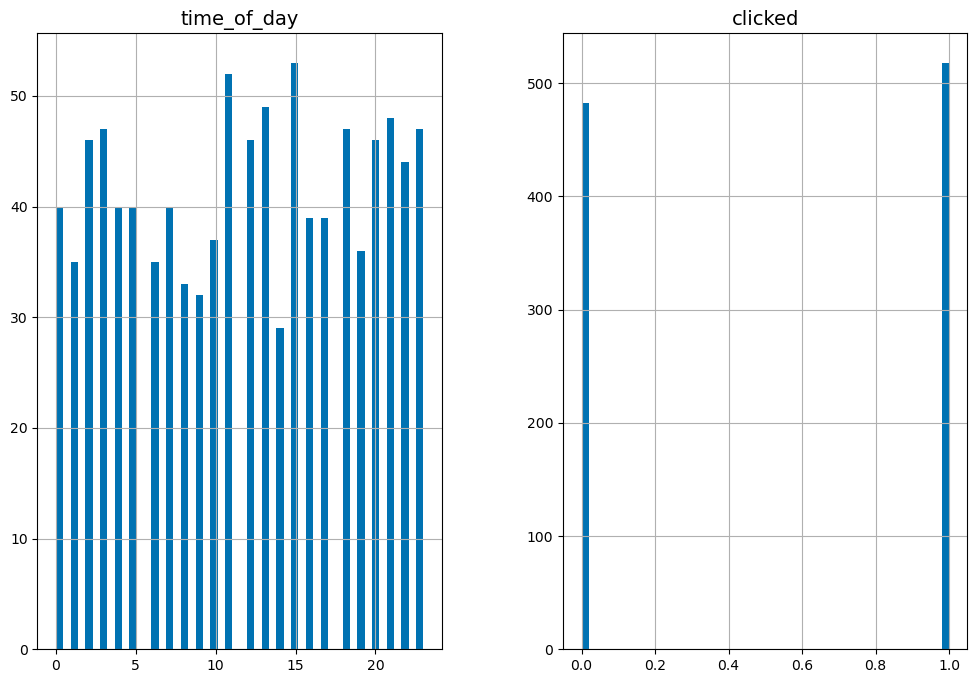

In [10]:
# Plot hisogramas de distrubucion de variables numéricas en base de datos
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.show()


## Análisis Estadístico

## Visualización

Image saved at ./data/Barplot_audience_clicked.png


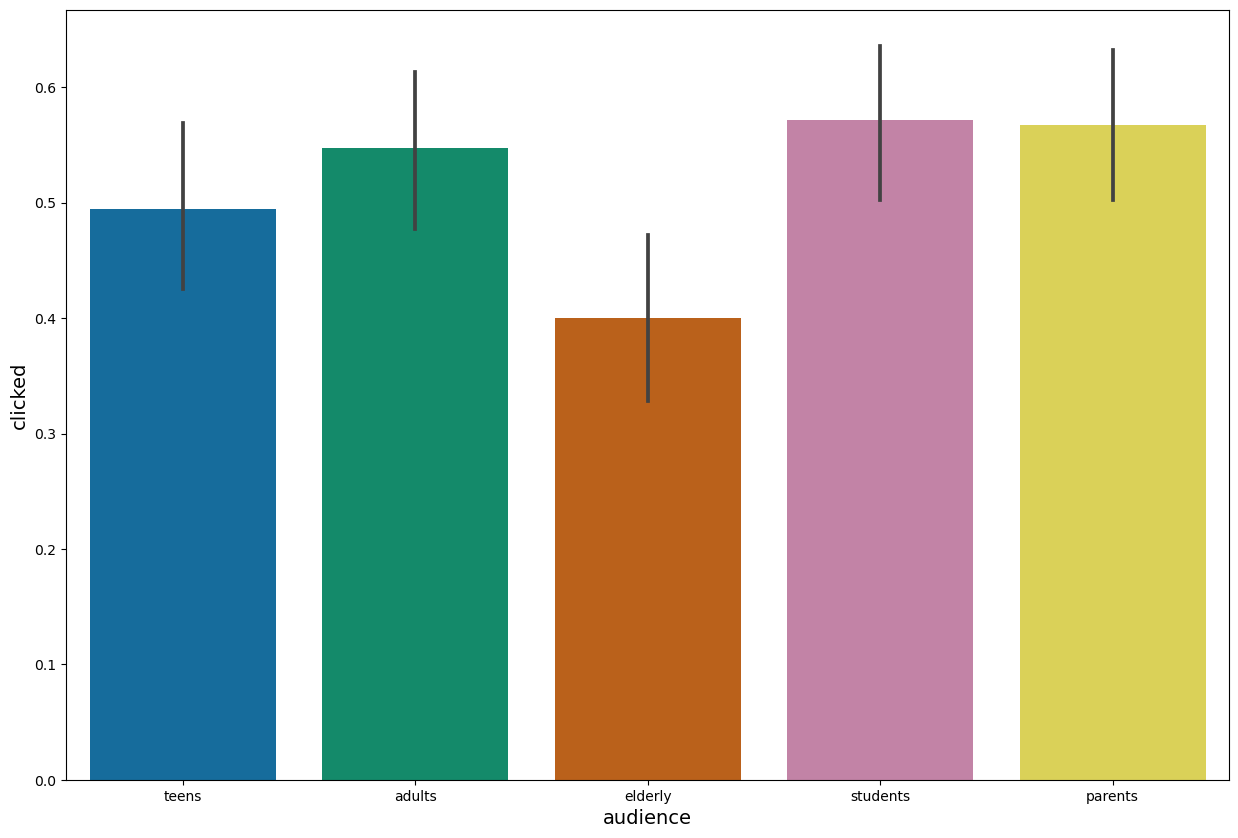

In [11]:
# gráfico de barra 
# y target (clic) vs. x clase
explore.discrete_var_barplot(x='audience',y='clicked',data=df,output_path='./data/')

Image saved at ./data\Countplot_clicked.png


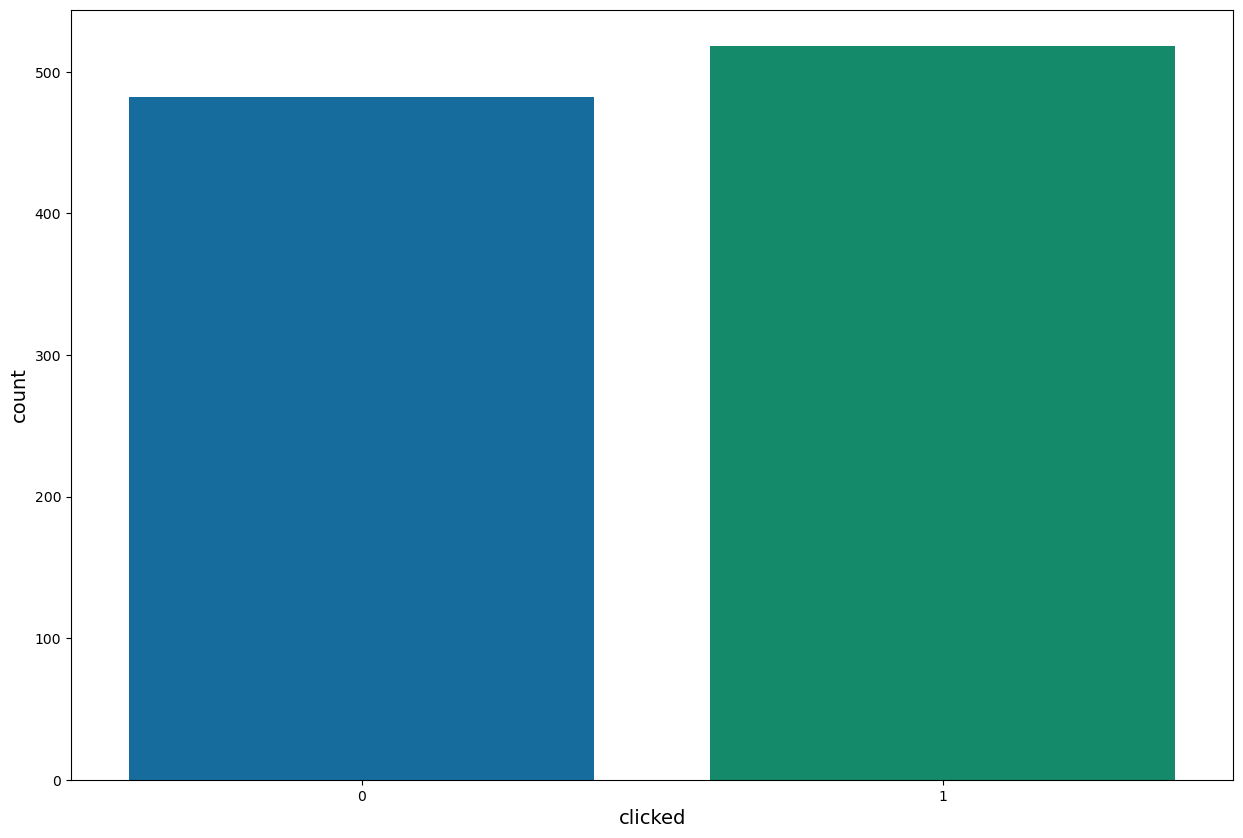

In [12]:
# count plot: contar observaciones por categoria en columna 
# x= 'clicked'
explore.discrete_var_countplot(x='clicked',data=df,output_path='./data')

Image saved at ./data\Boxplot_audience_clicked.png


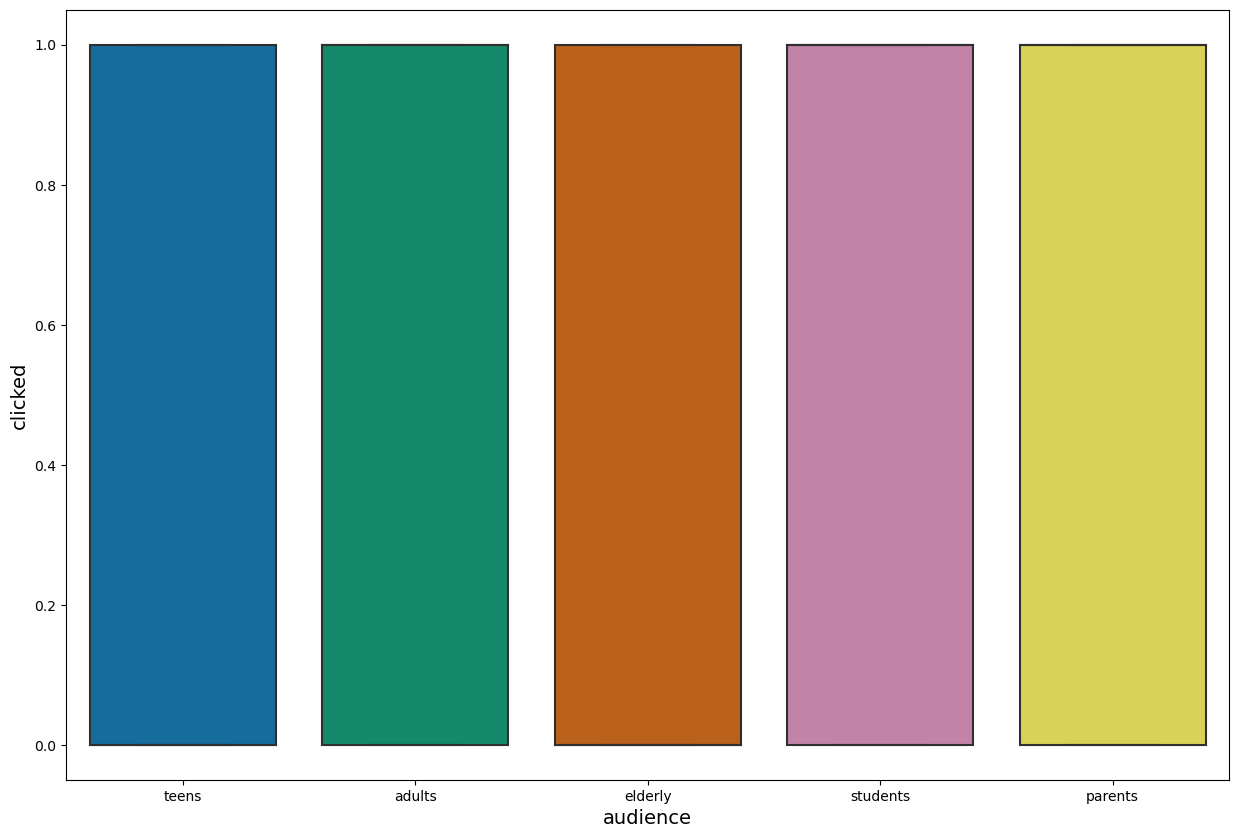

In [13]:
# box plot 
# y Fare vs. x clase
explore.discrete_var_boxplot(x='audience',y='clicked',data=df,output_path='./data')

## Técnicas de Correlación

In [14]:
# crear matriz de correlación entre variables numericas en base de datos 
corr_matrix = df.corr()
corr_matrix

C:\Users\Diego\AppData\Local\Temp\ipykernel_17312\1766072850.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


,time_of_day,clicked
time_of_day,1.000000,-0.054542
clicked,-0.054542,1.000000


In [15]:
# correlación con 'variable ' especifica target
corr_matrix["clicked"].sort_values(ascending=False)

clicked        1.000000
time_of_day   -0.054542
Name: clicked, dtype: float64

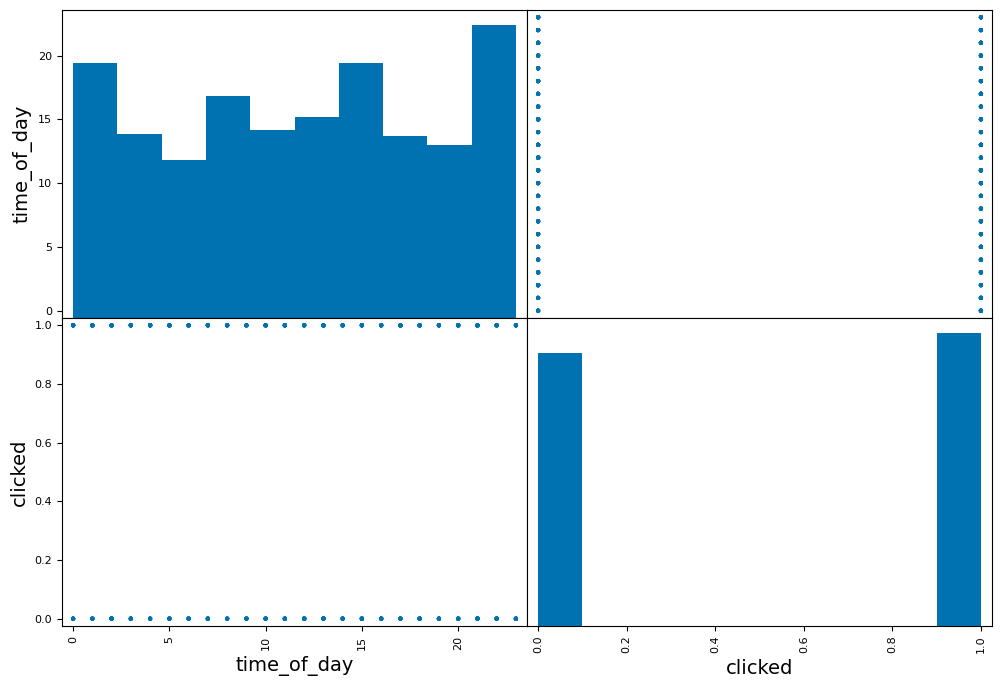

In [16]:
# Plot matriz de dispersion entre variables numéricas
# variables numericas: "time_of_day", "clicked"
attributes = ["time_of_day", "clicked"]
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()


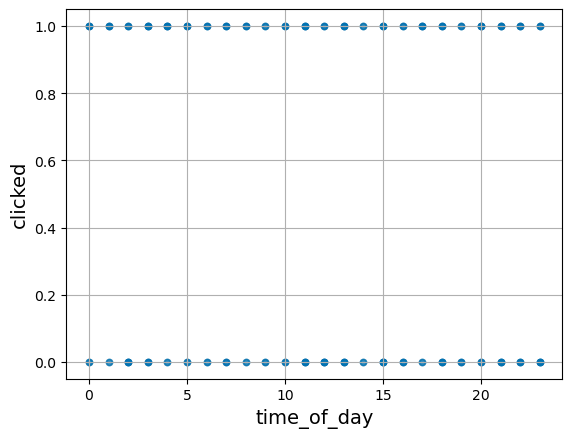

In [17]:
# gráfico de dispersión entre variables numéricas
df.plot(kind="scatter", x="time_of_day", y="clicked",
             alpha=0.1, grid=True)
plt.show()

c:\Users\Diego\Documents\GitHub\tech_skills\auxiliar\funciones\data_exploration\explore.py:179: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data.corr()


Image saved at ./data/Corr_plot.png


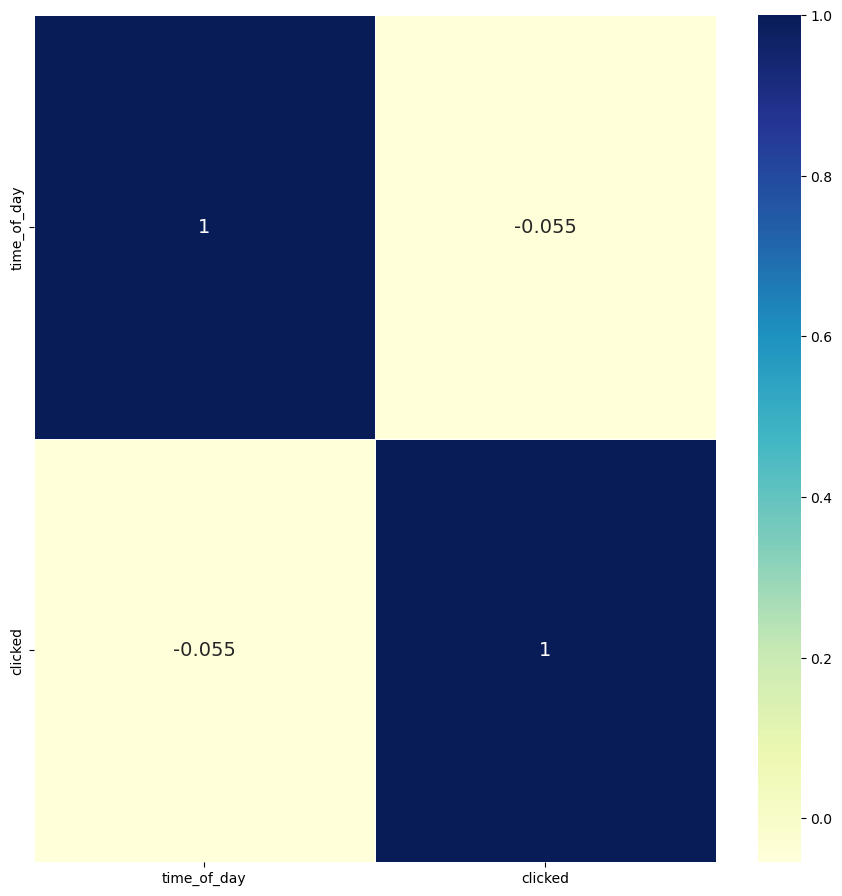

In [19]:
# gráfico de correlación entre columnas (variables) de DataFrame
explore.correlation_plot(data=df,output_path='./data/')


# ML Pipelines

In [20]:
# copiar base de datos
data_copy = df.copy(deep=True)
data_copy


,copy,audience,keywords,time_of_day,clicked
0,Hurry up!,teens,bestseller,14,0
1,Hurry up!,teens,discount,16,1
2,Limited offer!,teens,bestseller,12,1
3,Don't miss out!,adults,sale,14,1
4,Limited offer!,teens,sale,16,0
...,...,...,...,...,...
995,Don't miss out!,teens,offer,23,0
996,Buy now!,parents,discount,20,1
997,Buy now!,students,limited,15,1
998,Buy now!,teens,exclusive,20,0


## Separar x variables, y target (dependiente)

In [21]:
# definir variables
x = data_copy.drop(columns='clicked')
y = data_copy['clicked'] # y dependiente (class)



## Separar base de datos en datos de entrenamiento y datos de prueba

In [22]:
# dividir base de datos en datos de entrenamiento y datos de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train

,copy,audience,keywords,time_of_day
382,Don't miss out!,adults,limited,21
994,50% off!,elderly,discount,16
982,Limited offer!,students,limited,3
47,Limited offer!,elderly,sale,9
521,Buy now!,teens,exclusive,19
...,...,...,...,...
767,Buy now!,students,sale,21
72,Hurry up!,adults,limited,8
908,Best in town!,students,sale,12
235,Best in town!,adults,exclusive,18


## ML Pipelines

In [23]:
# extraer nombres de columnas por tipo 
# retorna tupla de listas con nombres de columnas por tipo

def columns_types(data):
    
    # definir estrucutra de datos por tipo de variable
    numeric_types=['int', 'int32', 'int64', 'float', 'float32', 'float64']
    category_types = ['object','category']
    str_types = ['string']
    bool_types = ['bool']
    date_types = ['datetime64', 'datetime', 'datetime64[ns]']
    
    # listas de nombres de variables
    numeric_columns = []
    str_columns = []
    bool_columns = []
    date_columns = []
    category_columns = []

    for column in data.columns:
        
        col_type = str(data[column].dtype)
        
        if any(col_type.startswith(t) for t in numeric_types) or any(col_type.startswith(t) for t in numeric_types):
            numeric_columns.append(column)
        elif any(col_type.startswith(t) for t in str_types):
            str_columns.append(column)
        elif any(col_type.startswith(t) for t in bool_types):
            bool_columns.append(column)
        elif any(col_type.startswith(t) for t in date_types):
            date_columns.append(column)
        elif any(col_type.startswith(t) for t in category_types):
            category_columns.append(column)
            

    return numeric_columns, category_columns, str_columns,bool_columns, date_columns


In [24]:
# extraer nombres de columnas por tipo 
numeric_columns, category_columns, str_columns,bool_columns, date_columns = columns_types(x)
numeric_columns, category_columns, str_columns,bool_columns, date_columns


(['time_of_day'], ['copy', 'audience', 'keywords'], [], [], [])

In [25]:
# crear pipeline para variables numericas
# imputador simple por mediana
# escalador estandar 
num_pipeline = make_pipeline(
  SimpleImputer(strategy="mean"),
  StandardScaler())

# crear pipeline para variables categiricas
# imputador simple por moda
# codificador one-hot [0-1]
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


In [26]:


# crear ML pipeline 
# variables numéricas: num_pipeline
# variables categóricas: cat_pipeline
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)



In [27]:
# crear pipeline end-to-end
# Regresión (y dependiente: )
# ML pipeline preprocesamiento + random_forest
full_pipeline1 = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=1, n_jobs=-1)),
])

# crear grid de hiper parametros de modelo
param_grid = [
    {'random_forest__n_estimators': [50, 100, 200],
      'random_forest__max_features' : ['sqrt','log2',3,5],
      'random_forest__max_depth' : [2,3,5],
      'random_forest__max_features' : ['sqrt','log2',3,5]
    },
    
    {'random_forest__n_estimators': [200, 300, 150],
      'random_forest__max_features' : [3,5,7],
      'random_forest__max_depth' : [2,3,5],
      'random_forest__max_features' : ['sqrt',3,5]
    }
    
]

# ver lista de parámetros
# pipeline__param 
params_list = list(full_pipeline1.get_params().keys() )
params_list

# GridSearchCV: sintonizador de hiper parametros
# parametros: ML pipeline, grid de hiper parametros, particiones (cv)
# scoring: metrica de evaluación a optimizar
grid_search = GridSearchCV(full_pipeline1, param_grid, cv=5,
                           scoring='recall')

# sintonizar GridSearchCV con datos de entrenamiento
grid_search.fit(x, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000224673EA3D0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy...
                                       ('random_forest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             param_grid=[{'random_forest__max_depth': [2, 3, 5],
                          'random_forest__max_features': ['sqrt', 'log2', 3, 5],
                          'random_forest__n_estimators': [50, 100, 200]},
                         {'random_forest__max_depth': [2, 3, 5],
                          'random_forest__max_features': ['sqrt', 3, 5],
                          'random_forest__n_estimators': [200, 300, 150]}],
             scoring='recall')

In [28]:
# mejores hiper parametros
grid_search.best_params_

{'random_forest__max_depth': 2,
 'random_forest__max_features': 3,
 'random_forest__n_estimators': 300}

In [29]:
# mejor ML pipeline1
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022466CBD050>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022466F93C50>)])),
                ('random_forest',
                 RandomForestClassifier(max_depth=2, max_features=3,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=1))])

In [30]:
# ver resultados de validación cruzada
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.340806,0.021685,0.076757,0.012992,2,3,300,"{'random_forest__max_depth': 2, 'random_forest...",0.873786,0.815534,0.855769,0.701923,0.884615,0.826326,0.066498,1
8,0.191838,0.013048,0.044577,0.001855,2,3,200,"{'random_forest__max_depth': 2, 'random_forest...",0.864078,0.796117,0.875000,0.701923,0.884615,0.824347,0.068646,2
39,0.213993,0.023557,0.048333,0.004244,2,3,200,"{'random_forest__max_depth': 2, 'random_forest...",0.864078,0.796117,0.875000,0.701923,0.884615,0.824347,0.068646,2
41,0.199487,0.014858,0.050171,0.013099,2,3,150,"{'random_forest__max_depth': 2, 'random_forest...",0.864078,0.776699,0.855769,0.682692,0.884615,0.812771,0.074652,4
10,0.109143,0.001326,0.026987,0.000633,2,5,100,"{'random_forest__max_depth': 2, 'random_forest...",0.864078,0.737864,0.855769,0.653846,0.913462,0.805004,0.095065,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.173686,0.005994,0.037503,0.005784,5,5,150,"{'random_forest__max_depth': 5, 'random_forest...",0.728155,0.640777,0.692308,0.528846,0.711538,0.660325,0.071994,59
56,0.173701,0.006849,0.036299,0.001268,5,sqrt,150,"{'random_forest__max_depth': 5, 'random_forest...",0.737864,0.640777,0.682692,0.519231,0.701923,0.656497,0.075445,60
55,0.294234,0.014199,0.060802,0.001760,5,sqrt,300,"{'random_forest__max_depth': 5, 'random_forest...",0.718447,0.631068,0.692308,0.538462,0.701923,0.656441,0.065974,61
30,0.082158,0.009362,0.031384,0.017445,5,3,50,"{'random_forest__max_depth': 5, 'random_forest...",0.718447,0.669903,0.615385,0.528846,0.730769,0.652670,0.074089,62


## Evaluación de Modelo

In [31]:
# extraer mejor modelo de ML pipeline
final_model = grid_search.best_estimator_  # incluye preprocesamiento

# importancia de variables (interpretacion de modelo)
feature_importances = final_model["random_forest"].feature_importances_

# extraer importancia de variables 
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.1668200723502132, 'pipeline-2__audience_elderly'),
 (0.1612130748748769, 'pipeline-1__time_of_day'),
 (0.1587459392339999, 'pipeline-2__keywords_sale'),
 (0.06016751640919153, 'pipeline-2__audience_students'),
 (0.053576593112256474, 'pipeline-2__keywords_offer'),
 (0.049372145755030544, 'pipeline-2__audience_parents'),
 (0.04566840600027944, 'pipeline-2__audience_teens'),
 (0.04091083091499617, 'pipeline-2__copy_Hurry up!'),
 (0.03610018014012425, 'pipeline-2__keywords_exclusive'),
 (0.03367259747177006, 'pipeline-2__keywords_bestseller'),
 (0.031116147603326923, 'pipeline-2__keywords_discount'),
 (0.030308682734672125, 'pipeline-2__audience_adults'),
 (0.025928581432604406, 'pipeline-2__copy_Limited offer!'),
 (0.024659008398664126, 'pipeline-2__copy_50% off!'),
 (0.02447593576267908, 'pipeline-2__copy_Buy now!'),
 (0.022504708897945546, 'pipeline-2__keywords_limited'),
 (0.01787426919831049, 'pipeline-2__copy_Best in town!'),
 (0.01688530970905891, "pipeline-2__copy_Don't miss o